<a href="https://colab.research.google.com/github/NidhiGK/NetworkDetection/blob/main/DetectionPhase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
'''%%shell
jupyter nbconvert --to html /content/DetectionPhase.ipynb'''

'%%shell\njupyter nbconvert --to html /content/DetectionPhase.ipynb'

#Step 1 Extracting images from Graph

###Node Location and type saved as dict

In [ ]:
import cv2
import numpy as np

def getNodeLocations(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_copy = img.copy()
    shape_count = 0
    line_count = 0
    squareCount = 0
    circleCount = 0
    triangleCount = 0
    shapes={} #saves the position of the node (x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height
    lines={}
    prev_box=[[0, 0],[0, 0],[0, 0],[0, 0]]
    for cnt in contours:        
        area = cv2.contourArea(cnt) # This is used to find the area of the contour.
        #print("Area: ",area)
        if area>30: # The areas below 30 pixels will not be considered
            shape_count += 1
            cv2.drawContours(imgContour, cnt, -1, (255,0,0), 3) # -1 denotes that we need to draw all the contours
            perimeter = cv2.arcLength(cnt, True) # The true indicates that the contour is closed
            approx = cv2.approxPolyDP(cnt, 0.02*perimeter, True) # This method is used to find the approximate number of contours
            
            objCorner = len(approx)
            x,y,w,h = cv2.boundingRect(approx) # In this we get the values of our bounding box that we will draw around the object
            if objCorner==3:
                objectType = 'T'+str(triangleCount)
                triangleCount+=1
            elif objCorner==4:
                aspectRatio = float(w)/float(h)
                if aspectRatio > 0.95 and aspectRatio < 1.05:
                    objectType = 'S'+str(squareCount)
                    squareCount+=1
            elif objCorner>4:
                aspectRatio = float(w)/float(h)
                #if aspectRatio > 0.95 and aspectRatio < 1.05:
                objectType = "C"+str(circleCount)
                circleCount+=1
                #else:
                #    continue
            cv2.rectangle(imgContour, (x,y), (x+w,y+h), (0,255,0), 2) # Draw a rectange around the shapes
            shapes[shape_count] = [x,y,w,h,objectType[0], objectType[1:]]
        cv2.putText(imgContour,objectType,(x+(w//2)-10, y+(h//2)-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0),2)
    print("Number of contours: ", len(contours))
    print("squareCount:",squareCount)
    print("circleCount:",circleCount)
    print("triangleCount:",triangleCount)
    print("Lines:", lines, "\nShapes: ", shapes)


img = cv2.imread("test3.png")
imgContour = img.copy()
#imgInvert = cv2.bitwise_not(img)
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (7,7), 1)
imgCannyShapes = cv2.Canny(imgBlur,80, 100)
getNodeLocations(imgCannyShapes)

imgBlank = np.zeros_like(img)

#imgStack = stackImages(0.5, ([img,imgBlur],
#                             [imgCannyShapes,imgContour]))
#half = cv2.resize(imgContour, (0, 0), fx = 0.8, fy = 0.8)
#cv2.imshow("Stack", imgCannyShapes)
#cv2.imshow("Final", imgContour)
cv2.imwrite("shapeOutput_Shapes.png", imgContour)

#cv2.waitKey(0)

Number of contours:  708
squareCount: 1
circleCount: 64
triangleCount: 0
Lines: {} 
Shapes:  {1: [1033, 893, 110, 110, 'C', '0'], 2: [921, 893, 107, 109, 'C', '1'], 3: [798, 893, 108, 109, 'C', '2'], 4: [686, 893, 107, 109, 'C', '3'], 5: [561, 893, 110, 109, 'C', '4'], 6: [449, 893, 109, 110, 'C', '5'], 7: [327, 893, 108, 110, 'C', '6'], 8: [214, 893, 108, 109, 'C', '7'], 9: [113, 894, 86, 108, 'C', '7'], 10: [887, 831, 8, 9, 'C', '8'], 11: [870, 831, 8, 9, 'C', '9'], 12: [829, 791, 11, 11, 'C', '10'], 13: [844, 765, 139, 47, 'C', '11'], 14: [307, 723, 47, 21, 'C', '12'], 15: [756, 703, 7, 9, 'C', '13'], 16: [717, 703, 11, 11, 'C', '14'], 17: [782, 697, 41, 21, 'C', '15'], 18: [1115, 676, 8, 11, 'C', '16'], 19: [1049, 672, 93, 21, 'C', '17'], 20: [602, 672, 30, 21, 'C', '18'], 21: [323, 672, 11, 21, 'C', '19'], 22: [184, 672, 18, 21, 'C', '20'], 23: [1098, 652, 8, 10, 'C', '21'], 24: [1094, 646, 54, 21, 'C', '22'], 25: [779, 646, 44, 21, 'C', '23'], 26: [609, 645, 17, 22, 'C', '24'], 2

True

###Line horizontal rectangle (x, y, w,h) endpoints and bounding box endpoints saved as dict

In [ ]:
def similarity(p1, p2, count, count2):
    #since it is detecting 2 lines per connection, I was trying to remove any lines with similar box endpoints
    #this checks the similarity
    s = 0
    #print("|||", count,"vs", count2, "|||", end = "")
    for p in range(4):
        x1, y1 = p1[p]
        x2, y2 = p2[p]
        val = abs(x1-x2) + abs(y1-y2)
        #print("x1, y1:", x1, y1, ", x2, y2:", x2, y2)
        if val<10:
            return 0
        s += val
    #print(count, ".S: ", s)
    return s

In [ ]:
##LINE DETECTION

def getLines(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_copy = img.copy()
    shape_count = 0
    line_count = 0
    squareCount = 0
    circleCount = 0
    triangleCount = 0
    shapes={} #saves the position of the node (x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height
    lines={}
    prev_box=[[0, 0],[0, 0],[0, 0],[0, 0]]
    for cnt in contours:        
        area = cv2.contourArea(cnt) # This is used to find the area of the contour.
        #print("Area: ",area)
        if area>80: # The areas below 500 pixels will not be considered
            shape_count += 1
            cv2.drawContours(imgContour, cnt, -1, (255,0,0), 3) # -1 denotes that we need to draw all the contours
            perimeter = cv2.arcLength(cnt, True) # The true indicates that the contour is closed
            approx = cv2.approxPolyDP(cnt, 0.02*perimeter, True) # This method is used to find the approximate number of contours
            
            objCorner = len(approx)
            x,y,w,h = cv2.boundingRect(approx) # In this we get the values of our bounding box that we will draw around the object
            if objCorner==3:
                objectType = 'T'+str(triangleCount)
                triangleCount+=1
            elif objCorner==4:
                aspectRatio = float(w)/float(h)
                if aspectRatio > 0.95 and aspectRatio < 1.05:
                    objectType = 'S'+str(squareCount)
                    squareCount+=1
            elif objCorner>4:
                aspectRatio = float(w)/float(h)
                #if aspectRatio > 0.95 and aspectRatio < 1.05:
                objectType = "C"+str(circleCount)
                circleCount+=1
                #else:
                #    continue
            #cv2.rectangle(imgContour, (x,y), (x+w,y+h), (0,255,0), 2) # Draw a rectange around the shapes
            shapes[shape_count] = [x,y,w,h,objectType[0], objectType[1:]]
            
        elif area<80: # The areas below 100 pixels are lines
            perimeter = cv2.arcLength(cnt, False) # The true indicates that the contour is closed
            approx = cv2.approxPolyDP(cnt, 0.02*perimeter, True) # This method is used to find the approximate number of contours
            objCorner = len(approx)
            x,y,w,h = cv2.boundingRect(approx) # In this we get the values of our bounding box that we will draw around the object
            objectType = "l"+str(line_count)+":"+str(objCorner)
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            try:
                if similarity(box, prev_box, line_count, line_count-1)<40:
                        continue
            except KeyError:
                print("Line throws error when line count is : ", line_count)
            line_count+=1
            cv2.drawContours(imgContour,[box],0,(0,255,0),2)
            #cv2.rectangle(imgContour, (x,y), (x+w,y+h), (0,255,0), 2) # Draw a rectange around the shapes
            lines[line_count] = {"xywh":(x, y, w, h), "endpoints": box}
            prev_box = box
            
        
        #print(objectType, "Perimeter: ", perimeter, "Corner Points: ", len(approx))
        #print("x,y,w,h:",x,y,w,h)
        cv2.putText(imgContour,objectType,(x+(w//2)-10, y+(h//2)-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0),2)
    #print("Number of contours: ", len(contours))
    #print("squareCount:",squareCount)
    #print("circleCount:",circleCount)
    #print("triangleCount:",triangleCount)
    #print("Lines:", lines, "\nShapes: ", shapes)
    return lines

imgContour = img.copy()
imgBlur = cv2.GaussianBlur(imgGray, (7,7), 1)
imgCannyShapes = cv2.Canny(imgBlur,30, 30)
lines = getLines(imgCannyShapes)
print(lines)

#imgStack = stackImages(0.5, ([img,imgBlur],
#                             [imgCannyShapes,imgContour]))
#half = cv2.resize(imgContour, (0, 0), fx = 0.8, fy = 0.8)
#cv2.imshow("Stack", imgCannyShapes)
#cv2.imshow("Final", imgContour)
cv2.imwrite("shapeOutput_Lines.png", imgContour)

#cv2.waitKey(0)

{1: {'xywh': (1, 1014, 1, 3), 'endpoints': array([[   1, 1014],
       [   1, 1014],
       [   1, 1016],
       [   1, 1016]])}, 2: {'xywh': (106, 1008, 1, 1), 'endpoints': array([[ 106, 1008],
       [ 106, 1008],
       [ 106, 1008],
       [ 106, 1008]])}, 3: {'xywh': (278, 1006, 2, 1), 'endpoints': array([[ 278, 1006],
       [ 278, 1006],
       [ 279, 1006],
       [ 279, 1006]])}, 4: {'xywh': (951, 1005, 2, 1), 'endpoints': array([[ 951, 1005],
       [ 951, 1005],
       [ 952, 1005],
       [ 952, 1005]])}, 5: {'xywh': (778, 1005, 5, 5), 'endpoints': array([[ 782, 1009],
       [ 778, 1009],
       [ 778, 1005],
       [ 782, 1005]])}, 6: {'xywh': (550, 1005, 1, 1), 'endpoints': array([[ 550, 1005],
       [ 550, 1005],
       [ 550, 1005],
       [ 550, 1005]])}, 7: {'xywh': (529, 1005, 2, 2), 'endpoints': array([[ 529, 1006],
       [ 528, 1005],
       [ 529, 1004],
       [ 530, 1005]])}, 8: {'xywh': (356, 1005, 2, 1), 'endpoints': array([[ 356, 1005],
       [ 356, 1005]

True

**Step Two - Section Two: ADDITION OF BUSINESS RULES  **






#adding a firewall element between the connections corresponding to component 3


In [ ]:
'''df = pd.read_csv('raw_data.csv')
print(df.to_string()) 

col_list = ["from", "to"]

from_list = list(df["from"])
to_list = list(df["to"])

for i in range(0,len(from_list)):
   #print([from_list[i], to_list[i]])  
   if 3 in [from_list[i], to_list[i]]:
    print("business rule to be inserted here: ", i)
    df.at[i,'to']=999
    print(df.at[i,'from'], df.at[i,'to'])
    df.loc[i+1]=[999, to_list[i]]
    print(df.loc[i])
    df.index = df.index + 1
    df = df.sort_index()
    #df1.at[i,'to']='4'
    #df1.loc[len(df1.index)] = ["4", to_list[i]]  # adding a row
    #df1.index = df1.index + 1  # shifting index
    #df1 = df1.sort_index()  
print(df)
df.to_csv("generated.csv", sep='\t')'''

'df = pd.read_csv(\'raw_data.csv\')\nprint(df.to_string()) \n\ncol_list = ["from", "to"]\n\nfrom_list = list(df["from"])\nto_list = list(df["to"])\n\nfor i in range(0,len(from_list)):\n   #print([from_list[i], to_list[i]])  \n   if 3 in [from_list[i], to_list[i]]:\n    print("business rule to be inserted here: ", i)\n    df.at[i,\'to\']=999\n    print(df.at[i,\'from\'], df.at[i,\'to\'])\n    df.loc[i+1]=[999, to_list[i]]\n    print(df.loc[i])\n    df.index = df.index + 1\n    df = df.sort_index()\n    #df1.at[i,\'to\']=\'4\'\n    #df1.loc[len(df1.index)] = ["4", to_list[i]]  # adding a row\n    #df1.index = df1.index + 1  # shifting index\n    #df1 = df1.sort_index()  \nprint(df)\ndf.to_csv("generated.csv", sep=\'\t\')'

 SECTION - DEFINING INTERFACES.

1.   raw_data consists of the component pairs with their explicit ids.

2.  id_to_comp consists of the mapping between explicit ids to their component type (1/2/3) with 999 corresponding to the business rules.

3. proc_data consists of the mapped component list after inclusion of business rules.

4. comp_to_id consists of component based marking to explicit id  for direct plotting.



In [ ]:
import pandas as pd
#will read csv from drive after section one generates
raw_data = {'from': ['1', '2', '3', '4','5','9','9','12','13','6','8','15','11','13','7','10','17','16','19','20','21','22'],'to': ['5', '5', '5', '5','9','12','13','16','16','11','11','11','12','14','14','14','14','18','18','18','18','18' ]}
df = pd.DataFrame(raw_data, columns = ['from', 'to'])
print(df)
df.to_csv('raw_data.csv', index=False)
!cp raw_data.csv "drive/My Drive/"

   from  to
0     1   5
1     2   5
2     3   5
3     4   5
4     5   9
5     9  12
6     9  13
7    12  16
8    13  16
9     6  11
10    8  11
11   15  11
12   11  12
13   13  14
14    7  14
15   10  14
16   17  14
17   16  18
18   19  18
19   20  18
20   21  18
21   22  18


In [ ]:

import pandas as pd
#will read csv from drive after section one generates
raw_data = {'1':[1,2,3,4,6,8,15,7,10,17,19,20,21,22],'2': [5,11,14,18,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1], '3':[9,12,16,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]}
df = pd.DataFrame(raw_data, columns = ['1', '2', '3'])
print(df)
df.to_csv('id_to_comp.csv', index=False)
!cp raw_data.csv "drive/My Drive/"

     1   2   3
0    1   5   9
1    2  11  12
2    3  14  16
3    4  18  13
4    6  -1  -1
5    8  -1  -1
6   15  -1  -1
7    7  -1  -1
8   10  -1  -1
9   17  -1  -1
10  19  -1  -1
11  20  -1  -1
12  21  -1  -1
13  22  -1  -1


In [ ]:
#classification of node ids to node components

def check_type(n):
  

  df1 = pd.read_csv('id_to_comp.csv')

  node_type_one = list(df1["1"])
  node_type_two = list(df1["2"])
  node_type_three = list(df1["3"])

  if n in node_type_one:
    return 1
  elif n in node_type_two:
    return 2
  elif n in node_type_three:
    return 3
  else:
    return 0

  

In [ ]:
import csv as csv

df = pd.read_csv('raw_data.csv')
df1 = pd.read_csv('id_to_comp.csv')

comp1=0
comp2=0

from_list = list(df["from"])
to_list = list(df["to"])

node_type_one = list(df1["1"])
node_type_two = list(df1["2"])
node_type_three = list(df1["3"])

header = ["from", "to"]
data1=[]
data2=[]

for item in from_list:
  comp1=check_type(item)
  print(item, comp1)
  data1.append(comp1)

for item in to_list:
  comp2=check_type(item) 
  data2.append(comp2)


with open('classified.csv', 'w') as f:
  
    writer = csv.writer(f)
    writer.writerow(header)

    for i in range(0,len(data1)):
      writer.writerow([data1[i],data2[i]])


1 1
2 1
3 1
4 1
5 2
9 3
9 3
12 3
13 3
6 1
8 1
15 1
11 2
13 3
7 1
10 1
17 1
16 3
19 1
20 1
21 1
22 1


**Adding Business Rules**

Assuming node component type- 3 to be a non secure source.
Insert a firewall between every connection that interacts with node 3.

In [ ]:
df2 = pd.read_csv('raw_data.csv')
print(df2)
from_list = list(df2["from"])
to_list = list(df2["to"])

header=["from", "to"]
with open('generated.csv', 'w') as f:
  
    writer = csv.writer(f)
    writer.writerow(header)
    
    for i in range(0,len(data1)):
      print([check_type(from_list[i]), check_type(to_list[i])])  
      if 3 in [check_type(from_list[i]), check_type(to_list[i])]:
        print("business rule to be inserted here: ", i)
        df2.at[i,"to"]=999
        new_row = {'from':999, 'to':to_list[i]}
#append row to the dataframe
        df2 = df2.append(new_row, ignore_index=True)
        df2.to_csv('generated.csv', index=False)
        print(df2)

!cp generated.csv "drive/My Drive/"


    from  to
0      1   5
1      2   5
2      3   5
3      4   5
4      5   9
5      9  12
6      9  13
7     12  16
8     13  16
9      6  11
10     8  11
11    15  11
12    11  12
13    13  14
14     7  14
15    10  14
16    17  14
17    16  18
18    19  18
19    20  18
20    21  18
21    22  18
[1, 2]
[1, 2]
[1, 2]
[1, 2]
[2, 3]
business rule to be inserted here:  4
    from   to
0      1    5
1      2    5
2      3    5
3      4    5
4      5  999
5      9   12
6      9   13
7     12   16
8     13   16
9      6   11
10     8   11
11    15   11
12    11   12
13    13   14
14     7   14
15    10   14
16    17   14
17    16   18
18    19   18
19    20   18
20    21   18
21    22   18
22   999    9
[3, 3]
business rule to be inserted here:  5
    from   to
0      1    5
1      2    5
2      3    5
3      4    5
4      5  999
5      9  999
6      9   13
7     12   16
8     13   16
9      6   11
10     8   11
11    15   11
12    11   12
13    13   14
14     7   14
15    10   14
16    17 

## Step 3: Visualization of Graph with business rules

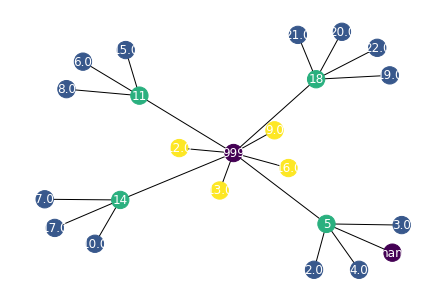

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('generated.csv')

G=nx.from_pandas_edgelist(df, 'from', 'to')

val_map = pd.read_csv('id_to_comp.csv')

#print(G.nodes())
dict={}
x=0
for col in val_map.columns:
    for item in val_map[col]:
        x=int(item)
        dict[x]=int(col)
 
    
values = [dict.get(node, 0.25) for node in G.nodes()]
nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()
